In [1]:
import datetime
import jsonlines
import os
import pandas as pd
import numpy as np
%matplotlib inline

## Build dataset

In [2]:
# Load user tweets
files = ['data/' + f for f in os.listdir("data")]
L = []
for path in files:
    try:
        with jsonlines.open(path, mode='r') as reader:
            tmp = [line for line in reader.iter()]
            if len(tmp) > 50 & isinstance(tmp, list):
                L.extend(tmp)
            else:
                print("%s had less than 50 tweets. skipping.." %path)
    except:
        print("Did not manage to process: %s" % path) 

Did not manage to process: data/.DS_Store
data/Are.jsonl had less than 50 tweets. skipping..
data/erna.jsonl had less than 50 tweets. skipping..
data/mav.jsonl had less than 50 tweets. skipping..


In [3]:
raw = pd.DataFrame(L)
raw.timestamp = pd.to_datetime(raw.timestamp)
print(raw.shape)
raw.head()

(434799, 7)


,id,likes,retweets,text,timestamp,url,user
0,1611815441,0,0,"Er på landsmøte Venstre, Stavanger, og ser fre...",2009-04-27 14:00:00,/abidraja/status/1611815441,abidraja
1,1611821893,0,0,"Er på #Venstrelm, og ser frem til kontantstøtt...",2009-04-25 17:00:00,/abidraja/status/1611821893,abidraja
2,1678440161,0,0,"Planlegger dialogmøtet 10. mai, men trenger pa...",2009-05-04 20:00:00,/abidraja/status/1678440161,abidraja
3,1804719114,0,0,Vi trenger kanskje et bleieskiftepoliti? http:...,2009-05-15 20:00:00,/abidraja/status/1804719114,abidraja
4,1815109460,0,0,"Støl etter hard treningsøkt i går, men føles j...",2009-05-18 01:00:00,/abidraja/status/1815109460,abidraja


In [4]:
counts = raw.user.value_counts()
print(counts)
counts = counts[counts > 50]
keep_users = counts.index

Aftenposten        61409
oslopolitiops      45360
TV2Paasche         38018
Orjas62            36762
Regjeringen        29265
KrohnTraaseth      27541
Hordalandpoliti    19390
kristin            15191
konservativ        13000
linniiie           12942
FerdOwner          12720
Trinesg            10732
abidraja           10094
audunlysbakken     10089
Oslo110sentral      8564
aslaknore           8552
erlendloe           7670
UriksFredrik        5703
TV2Alsaker          5626
Morgenbladet        5224
VGanders            4531
jonasgahrstore      3111
eidsvag             2964
jensstoltenberg     2678
Rammnieu            2588
Stortinget          2404
sigridbt            2314
BjarteTjostheim     2133
Oslokommune         2092
SteinarSagen        2022
StianBlipp          1988
PolitiTrondelag     1789
livenelvik          1761
bylvisaker          1660
jennyskavlan        1612
SenkveldTV2         1505
KongenDin           1488
Kronprinsparet      1469
fabianstang         1426
KrFNorge            1250


In [5]:
import re
def tokenizeString(s):
    s = s.lower().strip()
    s = re.sub(u"([.!?])", r" \1", s)
    s = re.sub(u"[^a-zA-Z.!#@?\xf8\xe6\xe5]+", u" ", s)
    s = s.split(" ")
    return s

user
Aftenposten        Axes(0.125,0.125;0.775x0.755)
BjarteTjostheim    Axes(0.125,0.125;0.775x0.755)
DavyWathne         Axes(0.125,0.125;0.775x0.755)
EspenEckbo         Axes(0.125,0.125;0.775x0.755)
FerdOwner          Axes(0.125,0.125;0.775x0.755)
GeirLippestad      Axes(0.125,0.125;0.775x0.755)
Giertsen           Axes(0.125,0.125;0.775x0.755)
Hordalandpoliti    Axes(0.125,0.125;0.775x0.755)
KongenDin          Axes(0.125,0.125;0.775x0.755)
KrFNorge           Axes(0.125,0.125;0.775x0.755)
KrohnTraaseth      Axes(0.125,0.125;0.775x0.755)
Kronprinsparet     Axes(0.125,0.125;0.775x0.755)
Morgenbladet       Axes(0.125,0.125;0.775x0.755)
Orjas62            Axes(0.125,0.125;0.775x0.755)
Oslo110sentral     Axes(0.125,0.125;0.775x0.755)
Oslokommune        Axes(0.125,0.125;0.775x0.755)
PSTnorge           Axes(0.125,0.125;0.775x0.755)
PetterNorthug1     Axes(0.125,0.125;0.775x0.755)
PetterNorthugJr    Axes(0.125,0.125;0.775x0.755)
PolitiTrondelag    Axes(0.125,0.125;0.775x0.755)
Politidir      

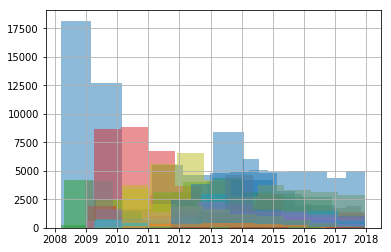

In [6]:
raw = (
    raw #[(raw.timestamp > '2015-01-01') & (raw.timestamp < '2017-01-01')]\
    [raw.user.isin(keep_users)]
    .sample(frac=1) # shuffle dataset
    .reset_index(drop=True)
      )
    
raw.groupby("user")['timestamp'].hist(alpha = 0.5)

## Build vocabulary

In [7]:
def build_vocabulary(text, min_count = 5):
    normalized = text.map(tokenizeString)
    all_words = np.array([item for sublist in normalized.values.tolist() for item in sublist])
    words, counts = np.unique(all_words, return_counts=True)
    keep_words = words[counts > min_count]
    ind2word = {i + 2 : w for i, w in enumerate(keep_words)}
    ind2word[1] = "UNK"
    ind2word[0] = "EMPTY"
    word2ind = {w : i for i, w in ind2word.items()}
    
    return word2ind, ind2word

word2ind, ind2word = build_vocabulary(raw.text)

## Preprocess text

In [8]:
# Prepare sequences:
from keras.preprocessing.sequence import pad_sequences
vectorize_tweet = lambda x: [word2ind.get(w,1) for w in x]
PAD_LENGTH = 40
def encode_text(s, padlen = PAD_LENGTH):
    tokenized = tokenizeString(s)
    vectorized = vectorize_tweet(tokenized)
    padded = pad_sequences([vectorized], maxlen = padlen, padding = "post", truncating= "post")
    return padded

def decode_tweet(vec):
    dec = [ind2word.get(ind) for ind in vec if ind != 0]
    
    return " ".join(dec)

Using TensorFlow backend.


In [9]:
X = np.squeeze(np.array(raw.text.map(encode_text).values.tolist()))#.shape

In [10]:
X.shape

(434777, 40)

In [11]:
decode_tweet(encode_text("nå er det barneskirenn").flatten())

'nå er det barneskirenn'

In [12]:
# Check length of tweets:
#raw.text_index.map(len).hist()

In [13]:
from sklearn import preprocessing
def build_classes(labels):
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    label_index = le.transform(labels)
    ind2class = {i : user for i, user in  enumerate(le.classes_)}
    return label_index, ind2class

In [14]:
raw['user_class'], ind2class = build_classes(raw['user'])

In [15]:
N_classes = len(ind2class)
N_classes

54

In [16]:
y = raw.user_class.values

In [17]:
np.random.seed(42)
all_in_both_groups = False
while not all_in_both_groups:
    train_ind = np.random.rand(X.shape[0]) < 0.8
    X_train = X[train_ind,]
    X_test = X[~train_ind,]
    y_train = y[train_ind]
    y_test = y[~train_ind]
    all_in_both_groups = len(np.unique(y_train)) ==  len(np.unique(y_test)) == N_classes
    print("train: %d, test : %d" % (len(np.unique(y_train)), len(np.unique(y_test))))

train: 54, test : 54


In [18]:
vocab = len(ind2word)
vocab

51801

## Build model

In [19]:
import keras
from keras.layers import *
from keras.models import Model

In [28]:
tweet_input = Input((PAD_LENGTH,))
emb = Embedding(vocab, 100)

In [29]:
word_vectors = emb(tweet_input)
word_vectors = Dropout(0.2)(word_vectors)

In [63]:
avg_word_vectors = Lambda(lambda x: K.mean(x, 1))(word_vectors)
x = Dense(100)(avg_word_vectors)
x = Dense(100)(x)
x = Dropout(0.2)(x)
x = Dense(N_classes, activation = "softmax")(x)


model = Model(inputs = tweet_input, outputs = x)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer = keras.optimizers.Adam(lr = 0.005), 
              metrics=["accuracy"])

In [64]:
"""
# LSTM MODEL
x = LSTM(10)(word_vectors)
x = Dense(3,activation = "softmax")(x)
model = Model(inputs = tweet_input, outputs = x)
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer = keras.optimizers.Adam(lr = 0.001), 
              metrics=["accuracy"])
"""

'\n# LSTM MODEL\nx = LSTM(10)(word_vectors)\nx = Dense(3,activation = "softmax")(x)\nmodel = Model(inputs = tweet_input, outputs = x)\nmodel.compile(loss="sparse_categorical_crossentropy", \n              optimizer = keras.optimizers.Adam(lr = 0.001), \n              metrics=["accuracy"])\n'

In [65]:
cl, count = np.unique(y_train, return_counts=True)
class_weight = {c : 1.0/np.sqrt(n) for c, n in zip(cl,count)}
tot = sum(class_weight.values())
class_weight = {i : w/tot for i, w in class_weight.items()}

In [66]:
model.fit(X_train,y_train, 
          verbose = 2,
          validation_data = (X_test, y_test),
         epochs = 15, class_weight=class_weight)

Train on 347825 samples, validate on 86952 samples
Epoch 1/15
114s - loss: 0.0097 - acc: 0.7234 - val_loss: 1.1618 - val_acc: 0.7078
Epoch 2/15
110s - loss: 0.0092 - acc: 0.7353 - val_loss: 1.1780 - val_acc: 0.6996
Epoch 3/15
111s - loss: 0.0090 - acc: 0.7406 - val_loss: 1.1422 - val_acc: 0.7082
Epoch 4/15
113s - loss: 0.0087 - acc: 0.7442 - val_loss: 1.1813 - val_acc: 0.7016
Epoch 5/15
112s - loss: 0.0086 - acc: 0.7468 - val_loss: 1.1460 - val_acc: 0.7093
Epoch 6/15
111s - loss: 0.0084 - acc: 0.7506 - val_loss: 1.1458 - val_acc: 0.7137
Epoch 7/15
110s - loss: 0.0083 - acc: 0.7535 - val_loss: 1.1029 - val_acc: 0.7239
Epoch 8/15
108s - loss: 0.0082 - acc: 0.7556 - val_loss: 1.1106 - val_acc: 0.7248
Epoch 9/15
108s - loss: 0.0081 - acc: 0.7584 - val_loss: 1.1049 - val_acc: 0.7201
Epoch 10/15
107s - loss: 0.0080 - acc: 0.7601 - val_loss: 1.1294 - val_acc: 0.7185
Epoch 11/15
107s - loss: 0.0079 - acc: 0.7621 - val_loss: 1.1056 - val_acc: 0.7253
Epoch 12/15
107s - loss: 0.0078 - acc: 0.7646

In [85]:
model.compile(loss="sparse_categorical_crossentropy", 
              optimizer = keras.optimizers.Adam(lr = 0.0005), 
              metrics=["accuracy"])
model.fit(X_train,y_train, 
          verbose = 2,
          validation_data = (X_test, y_test),
         epochs = 15, class_weight=class_weight)

Train on 347825 samples, validate on 86952 samples
Epoch 1/15
118s - loss: 0.0067 - acc: 0.7963 - val_loss: 1.0565 - val_acc: 0.7414
Epoch 2/15
112s - loss: 0.0067 - acc: 0.7985 - val_loss: 1.0631 - val_acc: 0.7392
Epoch 3/15
111s - loss: 0.0066 - acc: 0.7992 - val_loss: 1.0577 - val_acc: 0.7399
Epoch 4/15
113s - loss: 0.0066 - acc: 0.7995 - val_loss: 1.0573 - val_acc: 0.7417
Epoch 5/15
113s - loss: 0.0066 - acc: 0.7999 - val_loss: 1.0627 - val_acc: 0.7408
Epoch 6/15
112s - loss: 0.0066 - acc: 0.8004 - val_loss: 1.0606 - val_acc: 0.7402
Epoch 7/15
110s - loss: 0.0066 - acc: 0.8002 - val_loss: 1.0544 - val_acc: 0.7424
Epoch 8/15
108s - loss: 0.0065 - acc: 0.8012 - val_loss: 1.0552 - val_acc: 0.7417
Epoch 9/15
112s - loss: 0.0065 - acc: 0.8010 - val_loss: 1.0609 - val_acc: 0.7405
Epoch 10/15
113s - loss: 0.0065 - acc: 0.8008 - val_loss: 1.0613 - val_acc: 0.7403
Epoch 11/15
112s - loss: 0.0065 - acc: 0.8011 - val_loss: 1.0527 - val_acc: 0.7426
Epoch 12/15
113s - loss: 0.0065 - acc: 0.8022

In [86]:
yhat_probs = model.predict(X_test)
yhat = yhat_probs.argmax(axis=1)

In [87]:
from sklearn.metrics import confusion_matrix

In [88]:
confusion = confusion_matrix(y_test,yhat)
#confusion

In [89]:
rel_confusion = np.round(confusion / confusion.sum(axis=1, keepdims = True),2)
rel_confusion = pd.DataFrame(rel_confusion, columns = ind2class.values(), index= ind2class.values())
rel_confusion.index.name = "true"
rel_confusion.columns.name = "predicted"
rel_confusion

predicted,Aftenposten,BjarteTjostheim,DavyWathne,EspenEckbo,FerdOwner,GeirLippestad,Giertsen,Hordalandpoliti,KongenDin,KrFNorge,...,jensstoltenberg,jonasgahrstore,konservativ,kristin,linniiie,livenelvik,oslopolitiops,sigridbt,trulssv,vegardino
true,,,,,,,,,,,,,,,,,,,,,
Aftenposten,0.87,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
BjarteTjostheim,0.00,0.51,0.00,0.01,0.01,0.00,0.00,0.00,0.00,0.00,...,0.00,0.00,0.01,0.00,0.04,0.01,0.00,0.00,0.00,0.00
DavyWathne,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.05,0.00,0.00,0.00,0.11,0.00,0.00,0.00,0.03,0.00
EspenEckbo,0.02,0.00,0.00,0.10,0.04,0.01,0.02,0.01,0.00,0.01,...,0.00,0.01,0.01,0.02,0.04,0.02,0.00,0.00,0.01,0.00
FerdOwner,0.01,0.00,0.00,0.00,0.56,0.00,0.00,0.00,0.00,0.00,...,0.01,0.01,0.03,0.02,0.03,0.01,0.00,0.00,0.00,0.00
GeirLippestad,0.10,0.00,0.00,0.00,0.00,0.20,0.00,0.00,0.00,0.00,...,0.01,0.07,0.02,0.01,0.00,0.00,0.01,0.00,0.00,0.00
Giertsen,0.01,0.01,0.00,0.05,0.05,0.00,0.14,0.00,0.01,0.00,...,0.00,0.01,0.08,0.01,0.06,0.01,0.00,0.03,0.01,0.00
Hordalandpoliti,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.90,0.00,0.00,...,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.00,0.00,0.00
KongenDin,0.01,0.01,0.00,0.00,0.00,0.00,0.00,0.00,0.35,0.00,...,0.00,0.00,0.02,0.00,0.10,0.01,0.00,0.01,0.01,0.00


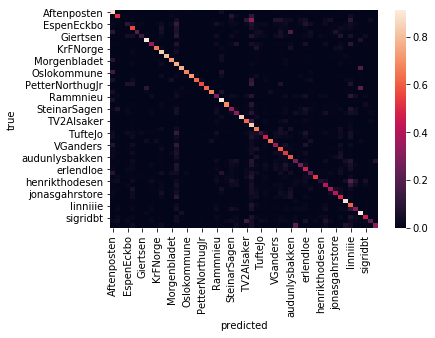

In [90]:
import seaborn as sns
sns.heatmap(rel_confusion)

In [91]:
tweet = "to menn pågrepet på akershus festning"
tweet = "dialog er viktig når man handler med utenlandske makter"
tweet = "vi single må få mer rettigheter"

In [92]:
def find_user(tweet, top = 3):
    v = encode_text(tweet)
    pred = model.predict(v)[0]
    top_ind = np.argsort(pred)[::-1][:top]
    return ", ".join(["%s : %.2f" % (ind2class[ind], pred[ind])  for ind in top_ind])

In [93]:
find_user("de single har det for dårlig i Norge")

'Trinesg : 0.14, linniiie : 0.11, UriksFredrik : 0.06'

In [94]:
find_user("det er viktig at noen passer på de som blir tatt av diplomatiet")

'linniiie : 0.21, henrikthodesen : 0.07, SteinarSagen : 0.07'

In [95]:
find_user("Jul er tiden for familien")

'linniiie : 0.15, TV2Paasche : 0.13, UriksFredrik : 0.06'

In [96]:
find_user("hva er meningen med livet?")

'TV2Paasche : 0.17, FerdOwner : 0.12, UriksFredrik : 0.07'

In [97]:
find_user("julenissen er pågrepet på nordpolen")

'oslopolitiops : 0.45, TufteJo : 0.10, Hordalandpoliti : 0.06'

In [98]:
find_user("#sport er meningen med livet")

'TV2Paasche : 0.18, FerdOwner : 0.11, UriksFredrik : 0.09'